# Libraries

In [169]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import multiprocessing
from gensim.models import Word2Vec as w2v
from time import time
import sklearn
from sklearn.manifold import TSNE
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from gensim.models.doc2vec import Doc2Vec as d2v, TaggedDocument

from gensim.models import Word2Vec
  
from nltk.cluster import KMeansClusterer
import nltk
import numpy as np 
  
from sklearn import cluster
from sklearn import metrics
import random

# Reading Data

In [128]:
df= pd.read_csv('E:/project/NLP/Data.csv')
df.shape

(279, 1)

In [129]:
df.isnull().sum()

Review Text    1
dtype: int64

In [130]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

Review Text    0
dtype: int64

In [131]:
df.head(5)

,Review Text
0,"Though asked to choose only one option, while ..."
1,"in any unfavorable business conditions, the co..."
2,There's a lot to learn and the organisation ha...
3,The organization starting right from the leade...
4,the company has many verticals under its fold ...


# Declaring Vaiables

In [132]:
sentences = []
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()
rx = r"\.(?=\S)"
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.ADJ)


# Removing Punctuations

In [133]:
r = []
for reviews in df['Review Text']:
    r.append(reviews)
    reviews = re.sub(rx, ". ", reviews)
    reviews = reviews.lower()
    reviews_without_punct = ""
    for char in reviews:
        if char not in punctuations:
            reviews_without_punct = reviews_without_punct + char
    sentences.append(reviews_without_punct.split())

# Remove Stopwords and Lemmatizing words

In [134]:
t = time()
for words in sentences:
    sent = ""
    sent = (" ").join(words)
    split = sent.split()
    for words_in_split in split:
        if words_in_split in stop_words:
            words.remove(words_in_split)
        else:
            lemma = lemmatizer.lemmatize(words_in_split, get_wordnet_pos(words_in_split))
            if words_in_split != lemma:
                words.remove(words_in_split)
                words.append(lemma)
print("Cleaning of words completed")
print("Time to train the model: ",round(time()-t),"seconds")
print("Total number of sentences found are: ",len(sentences))

Cleaning of words completed
Time to train the model:  5 seconds
Total number of sentences found are:  278


# Word2Vec

In [135]:
num_features = 300
min_word_count = 2
num_workers = multiprocessing.cpu_count()
context_size = 7
seed = 1
downsampling = 1e-3

In [136]:
word_2_vec = w2v(
    sg=1, 
    seed=seed, 
    workers=num_workers, 
    size=num_features, 
    min_count=min_word_count, 
    window=context_size, 
    sample = downsampling)

In [137]:
word_2_vec.build_vocab(sentences, progress_per = 10000)

In [138]:
t = time()
word_2_vec.train(sentences, total_examples=word_2_vec.corpus_count, epochs=30, report_delay=1)
print("Time to train the model: ",round(time()-t)," seconds")

Time to train the model:  2  seconds


In [139]:
word_2_vec.init_sims(replace=True)

In [140]:
word_2_vec.wv.most_similar(positive=["environment"])

[('mind', 0.9996620416641235),
 ('family', 0.9996460676193237),
 ('people', 0.9995251297950745),
 ('truly', 0.9995163679122925),
 ('thus', 0.9995049238204956),
 ('cause', 0.9994972944259644),
 ('extremely', 0.9994831681251526),
 ('kid', 0.999481737613678),
 ('matter', 0.9994781017303467),
 ('distraction', 0.9994529485702515)]

In [141]:
word_2_vec.wv.similarity("performance", 'great')

0.99907905

In [142]:
tsne = sklearn.manifold.TSNE(n_components =2, random_state =0)

In [143]:
all_word_vectors_matrix = word_2_vec.wv.vectors
all_word_vectors_matrix.shape

(417, 300)

In [144]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [145]:
points = pd.DataFrame(
    [
        (words, coords[0], coords[1])
        for words, coords in [
            (word, all_word_vectors_matrix_2d[word_2_vec.wv.vocab[word].index])
            for word in word_2_vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [146]:
points.head(10)

,word,x,y
0,choose,16.167955,7.387047
1,one,-1.279770,-16.036713
2,option,2.852685,-18.422819
3,strongly,0.429621,10.404810
4,company,17.633392,9.504357
5,top,26.581644,-12.058160
6,ask,-0.286578,4.651560
7,give,14.713511,-13.206553
8,business,5.459591,13.095108
9,set,-11.249622,1.133411


In [147]:
sns.set_context("poster")

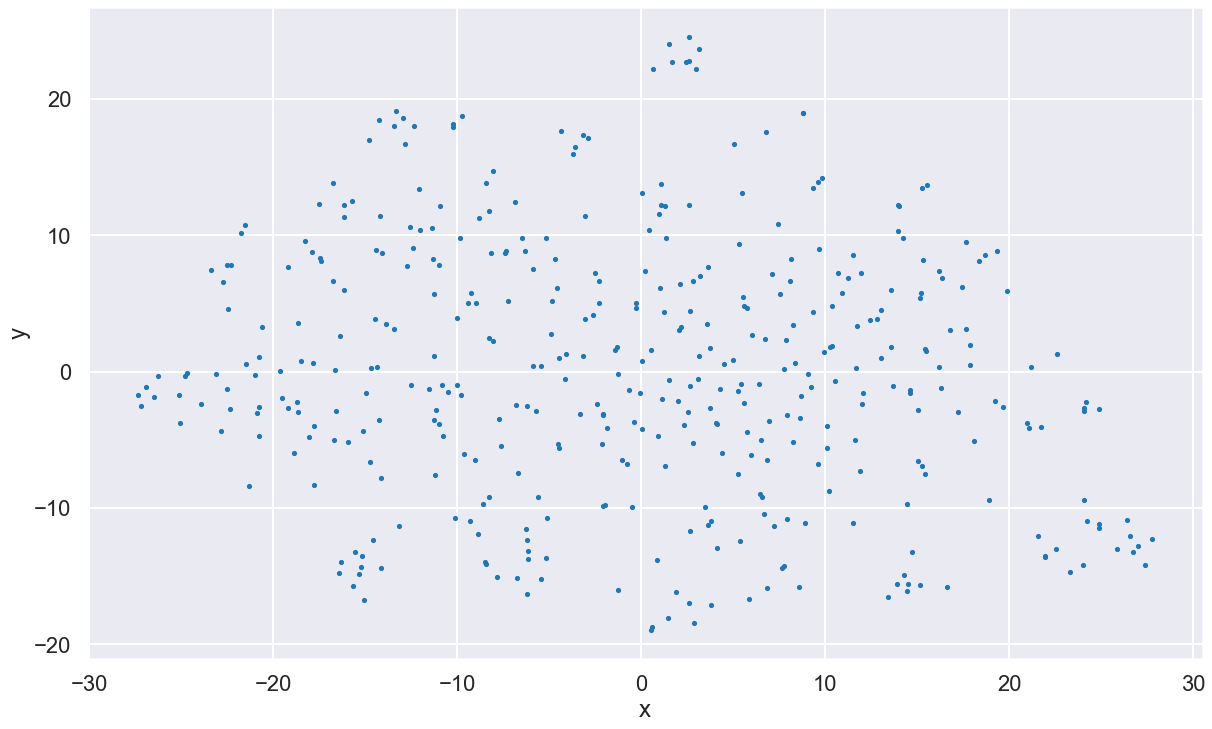

In [148]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [149]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

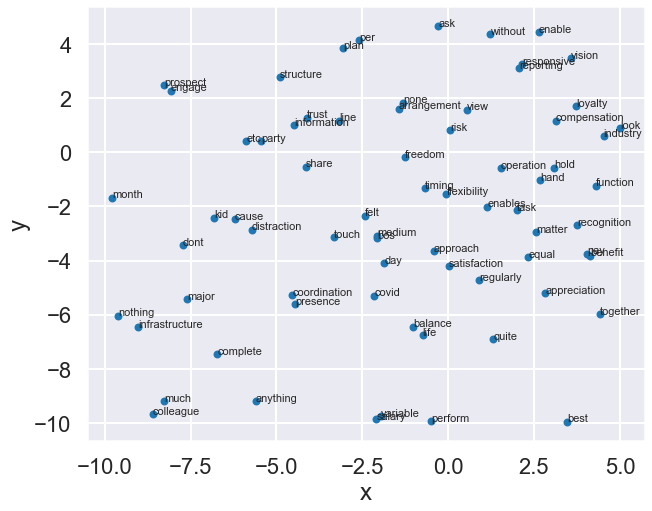

In [150]:
plot_region(x_bounds=(-10,5), y_bounds=(-10, 5))

# Clustering of words

In [151]:
n_clusters = 5
clusters = KMeans(n_clusters = n_clusters,
                 max_iter = 300,
                 init = 'k-means++',
                 n_init = 1)
label = clusters.fit_predict(all_word_vectors_matrix)

In [152]:
word_centroid_map = dict(zip(word_2_vec.wv.index2word, label ))

In [153]:
values_word_centroid = list(word_centroid_map.values())

In [154]:
keys_word_centroid = list(word_centroid_map.keys())

In [155]:
for cluster in range(0,n_clusters): 
    print ("\nCluster %d" % cluster)
    words = []
    for i in range(0,len(word_centroid_map.values())):
        if( values_word_centroid[i] == cluster ):
            words.append(keys_word_centroid[i])
    print (words)


Cluster 0
['employee', 'management', 'top', 'senior', 'high', 'manager', 'however', 'accountability', 'must', 'know', 'demand', 'bottom', 'bring', 'less']

Cluster 1
['business', 'client', 'new', 'also', 'challenge', 'one', 'way', 'meeting', 'personal', 'focus', 'communication', 'member', 'think', 'person', 'would', 'since', 'culture', 'respect', 'keep', 'development', 'difficult', 'believe', 'option', 'first', 'manner', 'towards', 'try', 'effective', 'customer', 'clear', 'along', 'execution', 'idea', 'video', 'meet', 'transaction', 'start', 'manage', 'result', 'attitude', 'advisory', 'future', 'build', 'tech', 'talk', 'timely', 'interaction', 'ready', 'right', 'centric', 'critical', 'portfolio', 'service', 'wish', 'commitment', 'true', 'plan', 'add', 'cant', 'short', 'minute', 'overall', 'ok', 'plutus', 'mainly', 'potential', 'sometime', 'miss', 'comfortable', 'especially', 'lockdown', 'account', 'prospect', 'phase', 'acquisition']

Cluster 2
['work', 'time', 'get', 'lot', 'require',

In [156]:
pca = PCA(n_components = 2).fit(all_word_vectors_matrix)
coords = pca.transform(all_word_vectors_matrix)
colors = ['#ff0000','#ff4000','#ff8000','#ffbf00','#ffff00','#bfff00','#80ff00','#40ff00','#00ff00','#00ff40','#00ff80','#00ffbf','#00ffff','#00bfff','#0080ff','#0040ff','#0000ff','#4000ff','#8000ff','#bf00ff','#ff00ff','#ff00bf','#ff0080','#ff0040','#ff0000']
label_colors = []
for i in range(n_clusters):
    label_colors.append(colors[i])

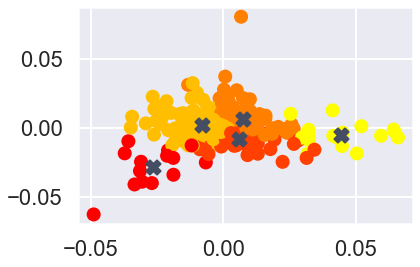

In [157]:
colors = [label_colors[i] for i in label]
plt.scatter(coords[:, 0], coords[:, 1], c=colors)
centroids = clusters.cluster_centers_
centroids_coords = pca.transform(centroids)
plt.scatter(centroids_coords[:, 0], centroids_coords[:, 1], marker="X", s=200, linewidths = 2, c="#444d61")
plt.show()

# Doc2Vec

In [158]:
tagged_sentence = [TaggedDocument(d, [i]) for i, d in enumerate(sentences)]
for i in range(10):
    print(tagged_sentence[i])

TaggedDocument(['though', 'choose', 'one', 'option', 'strongly', 'agree', 'company', 'top', 'ask', 'give', 'option'], [0])
TaggedDocument(['unfavorable', 'business', 'company', 'set', 'new', 'always', 'optimistic', 'ready', 'find', 'situation', 'condition', 'emerge', 'milestone', 'leader', 'opportunity'], [1])
TaggedDocument(['lot', 'learn', 'organisation', 'path', 'since', 'long', 'time', 'there', 'grow'], [2])
TaggedDocument(['organization', 'right', 'leadership', 'team', 'various', 'senior', 'value', 'care', 'organization', 'also', 'ample', 'growth', 'start', 'level', 'member', 'employee', 'provide', 'opportunity', 'challenge', 'learn'], [3])
TaggedDocument(['company', 'many', 'fold', 'delivery', 'one', 'roof', 'vertical', 'help', 'product'], [4])
TaggedDocument(['personal', 'touch', 'positive', 'covid', 'mr', 'abhishek', 'every', 'day', 'team', 'kapil', 'jeenesh', 'sakshi', 'felt', 'good', 'test', 'bos', 'medium', 'call', 'mate'], [5])
TaggedDocument(['entrepreneurial', 'spirit'], 

In [159]:
num_features = 300
min_word_count = 2
num_workers = multiprocessing.cpu_count()
context_size = 7
seed = 1
downsampling = 1e-3

In [160]:
doc_2_vec = d2v(
    seed=seed, 
    workers=num_workers, 
    vector_size=num_features, 
    min_count=min_word_count, 
    window=context_size, 
    sample = downsampling)

In [161]:
doc_2_vec.build_vocab(tagged_sentence, progress_per = 10000)

In [162]:
doc_2_vec.train(tagged_sentence, total_examples=doc_2_vec.corpus_count, epochs=30, report_delay=1)

In [163]:
doc_2_vec.init_sims(replace=True)

In [164]:
doc_2_vec.wv.similar_by_vector("environment")

[('business', 0.9998621344566345),
 ('company', 0.9998571872711182),
 ('work', 0.9998563528060913),
 ('give', 0.9998555183410645),
 ('time', 0.9998546838760376),
 ('good', 0.9998536109924316),
 ('home', 0.9998511075973511),
 ('like', 0.9998501539230347),
 ('need', 0.9998500347137451),
 ('organisation', 0.9998495578765869)]

In [165]:
doc_2_vec.wv.similarity("good", 'great')

0.9999157

In [166]:
all_sent_vectors_matrix = doc_2_vec.docvecs.vectors_docs
all_sent_vectors_matrix.shape

(278, 300)

In [167]:
print(all_sent_vectors_matrix[277])
print(all_sent_vectors_matrix.shape)

[-4.10908507e-03  3.82111818e-02  7.32506290e-02 -8.53955559e-03
  1.00955404e-01  2.42935847e-02  7.01139718e-02  1.04586847e-01
 -2.76390966e-02  2.31595412e-02 -1.00680977e-01  5.47937378e-02
 -4.77510765e-02  4.41602096e-02 -4.54898030e-02  6.29388914e-02
  1.24607965e-01  1.01697601e-01  1.35035226e-02 -3.83147295e-03
 -1.22050963e-01 -8.60934798e-03 -7.68468231e-02 -1.60259716e-02
 -6.74309433e-02 -1.01176146e-02  2.39043683e-02 -4.67715338e-02
 -8.80239084e-02  4.94741313e-02  4.71150987e-02  3.07830572e-02
  2.85850081e-04  1.39346167e-01  8.52316022e-02  3.31459977e-02
 -6.06757961e-02 -4.51356843e-02 -9.28260852e-03 -4.89906641e-03
  7.40121901e-02  4.41797189e-02  4.22574170e-02  1.29886672e-01
  8.97270814e-02  5.40621541e-02  4.70133014e-02 -7.38809444e-03
  2.29647234e-02  6.59298152e-02 -2.89156544e-03  2.92744171e-02
  5.82421310e-02  8.23526978e-02 -1.49807349e-01 -3.21527831e-02
  3.92153524e-02  2.14455798e-02 -1.14986598e-02 -1.70367770e-03
 -5.66829182e-02  8.56617

In [168]:
n_clusters = 5
clusters = KMeans(n_clusters = n_clusters,
                 max_iter = 300,
                 init = 'k-means++',
                 n_init = 1)
km = clusters.fit(all_sent_vectors_matrix)
label = km.predict(all_sent_vectors_matrix)
print(label)

[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [108]:
all_sent_vectors_matrix_2d = tsne.fit_transform(all_sent_vectors_matrix)

In [109]:
for j in range(len(sentences)):    
   print ("%s %s" % (label[j],  r[j])) 

0 Though asked to choose only one option, while I strongly agree that in this company all given options are on top.
0 in any unfavorable business conditions, the company has emerged and set  new milestones. leaders are always optimistic and ready to find opportunities out of any situation..
0 There's a lot to learn and the organisation has been on the growing path since a very long time
0 The organization starting right from the leadership team to various levels of senior members value and care about the employees. The organization also provides ample opportunities and challenges for learning and growth.  
0 the company has many verticals under its fold which helps in delivery of all products under one roof. 
0 There is a personal  touch.  I tested positive for covid.My boss Mr abhishek media called me every day and so did my team mates kapil  , jeenesh and sakshi.. I felt good about it
1 Entrepreneurial spirit
3 Company values people 
0 Got to learn a lot in terms of Facility Manageme

In [110]:
pca = PCA(n_components = 2).fit(all_sent_vectors_matrix)
coords = pca.transform(all_sent_vectors_matrix)

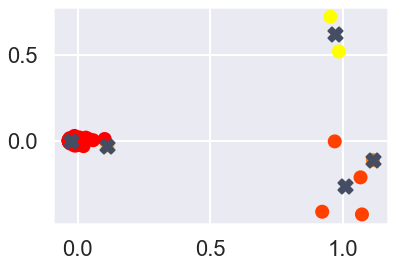

In [111]:
colors = [label_colors[i] for i in label]
plt.scatter(coords[:, 0], coords[:, 1], c=colors)
centroids = clusters.cluster_centers_
centroids_coords = pca.transform(centroids)
plt.scatter(centroids_coords[:, 0], centroids_coords[:, 1], marker="X", s=200, linewidths = 2, c="#444d61")
plt.show()

In [112]:
word_centroid_map_doc = dict(zip(doc_2_vec.wv.index2word, label ))

In [113]:
values_word_centroid_doc = list(word_centroid_map_doc.values())

In [114]:
keys_word_centroid_doc = list(word_centroid_map_doc.keys())

In [115]:
for cluster in range(0,n_clusters): 
    print ("\nCluster %d" % cluster)
    docs = []
    for i in range(0,len(word_centroid_map_doc.values())):
        if( values_word_centroid_doc[i] == cluster ):
            docs.append(keys_word_centroid_doc[i])
    print (docs)


Cluster 0
['work', 'employee', 'organisation', 'business', 'time', 'client', 'care', 'value', 'new', 'organization', 'team', 'take', 'company', 'issue', 'also', 'leadership', 'change', 'need', 'give', 'growth', 'management', 'make', 'internet', 'get', 'face', 'opportunity', 'grow', 'market', 'lot', 'challenge', 'good', 'home', 'help', 'like', 'always', 'well', 'require', 'nothing', 'online', 'one', 'top', 'senior', 'call', 'due', 'way', 'meeting', 'deal', 'connectivity', 'personal', 'every', 'performance', 'focus', 'set', 'leader', 'support', 'process', 'great', 'thing', 'communication', 'provide', 'feel', 'problem', 'connection', 'find', 'member', 'product', 'place', 'high', 'much', 'best', 'think', 'person', 'space', 'go', 'would', 'sometimes', 'since', 'long', 'level', 'many', 'term', 'culture', 'manager', 'professional', 'come', 'respect', 'individual', 'goal', 'keep', 'development', 'understand', 'difficult', 'believe', 'dont', 'access', 'mobile', 'option', 'achieve', 'available'